In [1]:
import os
import pandas as pd
import seaborn as sns
import random
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from math import floor

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, accuracy_score


In [2]:
data_folder = '../03.clean-data/'
results_folder = '../04.results/'


In [3]:
if not os.path.isdir(results_folder):
    if not os.path.exists(results_folder):
        os.mkdir(results_folder)
    else:
        raise NotADirectoryError

## Load Data

In [4]:
hpi = pd.read_csv(os.path.join(data_folder, 'hpi.csv'), parse_dates=['Date']) # Load
hpi.sort_values(['Area', 'Type', 'Date'], inplace=True) # Sort
hpi.reset_index(inplace=True)

In [5]:
hpi[(hpi['Area'] == 'City of Toronto') & hpi['HPI'].isnull()]

,level_0,index,Area,Date,Type,HPI


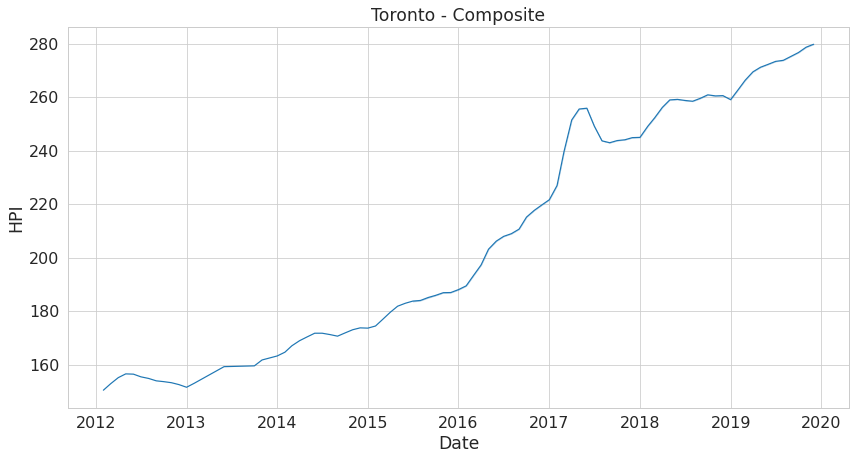

In [6]:
housing_type = 'Composite'
with sns.plotting_context("paper", font_scale=1.8):
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(
            data=hpi[(hpi['Type'] == housing_type) & hpi['Area'].isin(['City of Toronto']) & (hpi['Date'] > datetime(2012, 1, 1))],
            x='Date',
            y='HPI',
            estimator='mean'
        )
        ax.figure.set_figwidth(14)
        ax.figure.set_figheight(7)
        ax.set_title(f"Toronto - {housing_type}")
        fig = ax.get_figure()

## Calculate Monthly Changes ("Returns")

In [7]:
hpi_returns = hpi.copy()

In [8]:
hpi_returns['HPI.L1'] = hpi_returns.groupby(['Area', 'Type'])['HPI'].shift(1)
hpi_returns['rHPI'] = (hpi_returns['HPI'] - hpi_returns['HPI.L1']) / hpi_returns['HPI.L1']


In [9]:
all_areas = hpi_returns['Area'].unique().tolist()
some_better_known_areas = ['Brampton', 'Markham', 'Richmond Hill', 'City of Toronto', 'Mississauga', 'Vaughan']
print(all_areas)

['Adjala-Tosorontio', 'Ajax', 'Aurora', 'Brampton', 'Burlington', 'City of Toronto', 'Clarington', 'East Gwillimbury', 'Georgina', 'Halton Hills', 'Innisfil', 'Markham', 'Milton', 'Mississauga', 'New Tecumseth', 'Newmarket', 'Oakville', 'Orangeville', 'Oshawa', 'Pickering', 'Richmond Hill', 'Scugog', 'TREB Total', 'Toronto C01', 'Toronto C02', 'Toronto C03', 'Toronto C04', 'Toronto C06', 'Toronto C07', 'Toronto C08', 'Toronto C09', 'Toronto C10', 'Toronto C11', 'Toronto C12', 'Toronto C13', 'Toronto C14', 'Toronto C15', 'Toronto E01', 'Toronto E02', 'Toronto E03', 'Toronto E04', 'Toronto E05', 'Toronto E06', 'Toronto E07', 'Toronto E08', 'Toronto E09', 'Toronto E10', 'Toronto E11', 'Toronto W01', 'Toronto W02', 'Toronto W03', 'Toronto W04', 'Toronto W05', 'Toronto W06', 'Toronto W07', 'Toronto W08', 'Toronto W09', 'Toronto W10', 'Uxbridge', 'Vaughan', 'Whitby', 'Whitchurch-Stouffville']


## Training

In this notebook, I am not attempting to use VAR for forecasting. So, there is no "train/test" split - I will use the entire data set for training.

This is a model that we value for its explanatory power, not its predictive power. (In fact, if you see [05.C.VAR-in-differences.ipynb](05.C.VAR-in-differences.ipynb), you will realize that the model does not beat a simply benchmark in predicting HPI changes. 

In [10]:
# Remove areas & times with NULL values.
# Keep the areas that we want to study.
areas_of_interest = some_better_known_areas
# areas_of_interest = all_areas

gta_areas = hpi_returns[
    ~hpi_returns['Area'].str.startswith('Toronto')
    & (~hpi_returns['Area'].isin(['TREB Total', 'Clarington', 'Milton', 'Pickering']))
    & (hpi_returns['Area'].isin(areas_of_interest))
    & (hpi_returns['Date'].between(datetime(2015, 8, 1), datetime(2019, 12, 1)))
].copy()
additional_filter = gta_areas['Type'] == 'Composite'



In [11]:
gta_areas[additional_filter]['Area'].unique().tolist()

['Brampton',
 'City of Toronto',
 'Markham',
 'Mississauga',
 'Richmond Hill',
 'Vaughan']

In [12]:
train = (
    gta_areas
        [additional_filter]
        .pivot_table(values=['rHPI'], index=['Date'], columns='Area')
)
train.index = pd.DatetimeIndex(train.index).to_period('M')


In [13]:
train

rHPI                                                      \
Area     Brampton City of Toronto   Markham Mississauga Richmond Hill   
Date                                                                    
2015-08  0.007022    1.476041e-07  0.006512    0.005006      0.007456   
2015-09  0.002324    2.723111e-03 -0.000462    0.003874      0.009713   
2015-10  0.000580    2.701394e-03  0.006010    0.002756      0.010078   
2015-11  0.005214    2.686878e-03  0.003676    0.002749      0.002268   
2015-12 -0.001153    0.000000e+00  0.002747    0.004934      0.003620   
2016-01  0.016157    2.677207e-03 -0.000913    0.014184      0.015329   
2016-02  0.022147    3.989362e-03  0.026508    0.004303      0.012877   
2016-03  0.021667    1.002639e-02  0.030276    0.023567      0.032442   
2016-04  0.025014    1.034661e-02  0.031115    0.024594      0.029299   
2016-05  0.030239    1.495185e-02  0.048198    0.019408      0.054868   
2016-06  0.027806    7.381890e-03  0.020792    0.026052      0.020336   
2016-07  0.018537    4.364694e-03  0.014101    0.017090      0.018781   
2016-08  0.021643    2.403846e-03  0.009656    0.006241      0.014673   
2016-09  0.004333    4.066986e-03  0.016832    0.011927      0.015944   
2016-10  0.018696    1.067869e-02  0.011663    0.017445      0.027372   
2016-11  0.000941    5.808550e-03  0.008553    0.014365      0.008526   
2016-12  0.015515    4.593477e-03  0.012537    0.005939      0.007397   
2017-01  0.019444    4.551661e-03  0.002913    0.021344      0.001399   
2017-02  0.037693    1.195309e-02  0.017792    0.033793      0.023045   
2017-03  0.071772    2.797357e-02  0.070995    0.063226      0.056997   
2017-04  0.048591    2.461410e-02  0.046636    0.041667      0.054246   
2017-05  0.007399    8.151093e-03  0.014322   -0.001553      0.017152   
2017-06 -0.013529    5.868545e-04 -0.039849   -0.024893      0.003613   
2017-07 -0.047806   -1.309105e-02 -0.078105   -0.026725     -0.070207   
2017-08 -0.014815   -1.103531e-02 -0.029068   -0.022131     -0.037431   
2017-09 -0.013367   -1.436192e-03 -0.017525   -0.009640     -0.027824   
2017-10  0.001693    1.646091e-03 -0.007804   -0.004655     -0.012069   
2017-11 -0.004227    6.152584e-04 -0.002622    0.003401     -0.017452   
2017-12 -0.004244    1.638673e-03 -0.009012    0.004237     -0.017407   
2018-01  0.003410    2.041650e-04 -0.007579   -0.006751     -0.006508   
2018-02  0.007647    8.367347e-03  0.004200    0.006372     -0.002183   
2018-03  0.013491    6.423123e-03 -0.004563    0.017729      0.003282   
2018-04  0.004160    7.728894e-03  0.002292    0.010369      0.008724   
2018-05  0.009114    5.464481e-03 -0.001524    0.002874     -0.002162   
2018-06  0.011084    3.861004e-04  0.005725    0.000409      0.005056   
2018-07  0.002436   -7.716049e-04 -0.016319   -0.002046     -0.005031   
2018-08 -0.012556   -5.795981e-04  0.010031    0.004510     -0.015529   
2018-09  0.007383    2.127660e-03 -0.000382   -0.006122     -0.003668   
2018-10 -0.000407    2.503852e-03 -0.009935    0.010678     -0.010677   
2018-11 -0.000815   -7.665772e-04 -0.003474    0.000000      0.000744   
2018-12 -0.004077    1.919386e-04 -0.011232    0.001625     -0.005950   
2019-01  0.012689   -2.877974e-03  0.003134   -0.001217     -0.010475   
2019-02  0.001617    7.333076e-03  0.003905    0.013404     -0.009074   
2019-03  0.016546    6.656523e-03  0.003890    0.018437      0.013735   
2019-04  0.007543    5.818318e-03  0.005037    0.013774      0.009409   
2019-05  0.005516    3.153989e-03  0.000386    0.012422      0.005220   
2019-06  0.007445    2.028024e-03  0.000000    0.006135     -0.000742   
2019-07  0.005834    2.019831e-03  0.002312    0.000381     -0.002970   
2019-08  0.002320    7.315289e-04  0.004998    0.001905     -0.001117   
2019-10  0.013503    5.295836e-03  0.002295    0.011027      0.003354   
2019-11  0.001903    3.614022e-03  0.005344    0.012411      0.010030   
2019-12  0.011778    1.973448e-03  0.002658    0.005944     -0.004781  

In [14]:
train.isnull().any()

      Area           
rHPI  Brampton           False
      City of Toronto    False
      Markham            False
      Mississauga        False
      Richmond Hill      False
      Vaughan            False
dtype: bool

In [15]:
model = VAR(train)
criterion = {}
models = {}

for lag_order in range(1, 25):
    try:
        fitted = model.fit(lag_order, trend='c')
        models[lag_order] = fitted
        criterion[lag_order] = fitted.aic
    except:
        pass
# Next line chooses the model with the lowest AIC value.
selected_lag_order = list(dict(sorted(criterion.items(), key=lambda x:x[1])).keys())[0]
fitted = models[selected_lag_order]

### Model Selection

<AxesSubplot:>

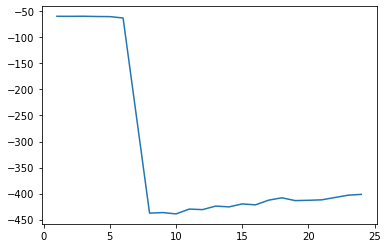

In [16]:
sns.lineplot(x=list(criterion.keys()), y=list(criterion.values()))

In [17]:
selected_lag_order

10

In [18]:
manually_selected_lag_order = 6

In [19]:
import numpy as np
np.linalg.eigvals(models[manually_selected_lag_order].sigma_u)

array([7.73512468e-04, 1.09261703e-06, 1.45528798e-05, 2.54892248e-05,
       4.63687727e-05, 4.39818983e-05])

### Research Question:

#### How does a unit change in prices in one of the panels in the data set impact the others?
The dotted lines, indicating the spread of the distribution of the impact, always have value 0 between them, indicating that there isn't a significant response by any one of the panels to a change in any one of the others.

Note that the leftmost value on the diagonals is always 1. This is by definition, a unit increase is an increase of 1 in the own signal, so this is why that number is always going to be 1. (The diagonals are the impulse responses to the same panel, so the a unit change is a change of 1 at t_0.) On the off-diagonals, the response at t_0 is always 0. This too is a mathematical property of the model and the definition of IRF - there is no contemporaneous impact built in to the model, hence the number has to be 0.

Notice how the diagonal elements tend to dip a little, and seem to converge to 0. This could be interpreted as evidence of market equilibrium in the sense that the price increases do not cause further price increases. In other words, if there is a higher increase month-to-month, that doesn't seem to lead to an even further, _divergent_ increases in monthly changes. This is what we would expect to see in stationary time series.

In [20]:
irf = models[manually_selected_lag_order].irf()

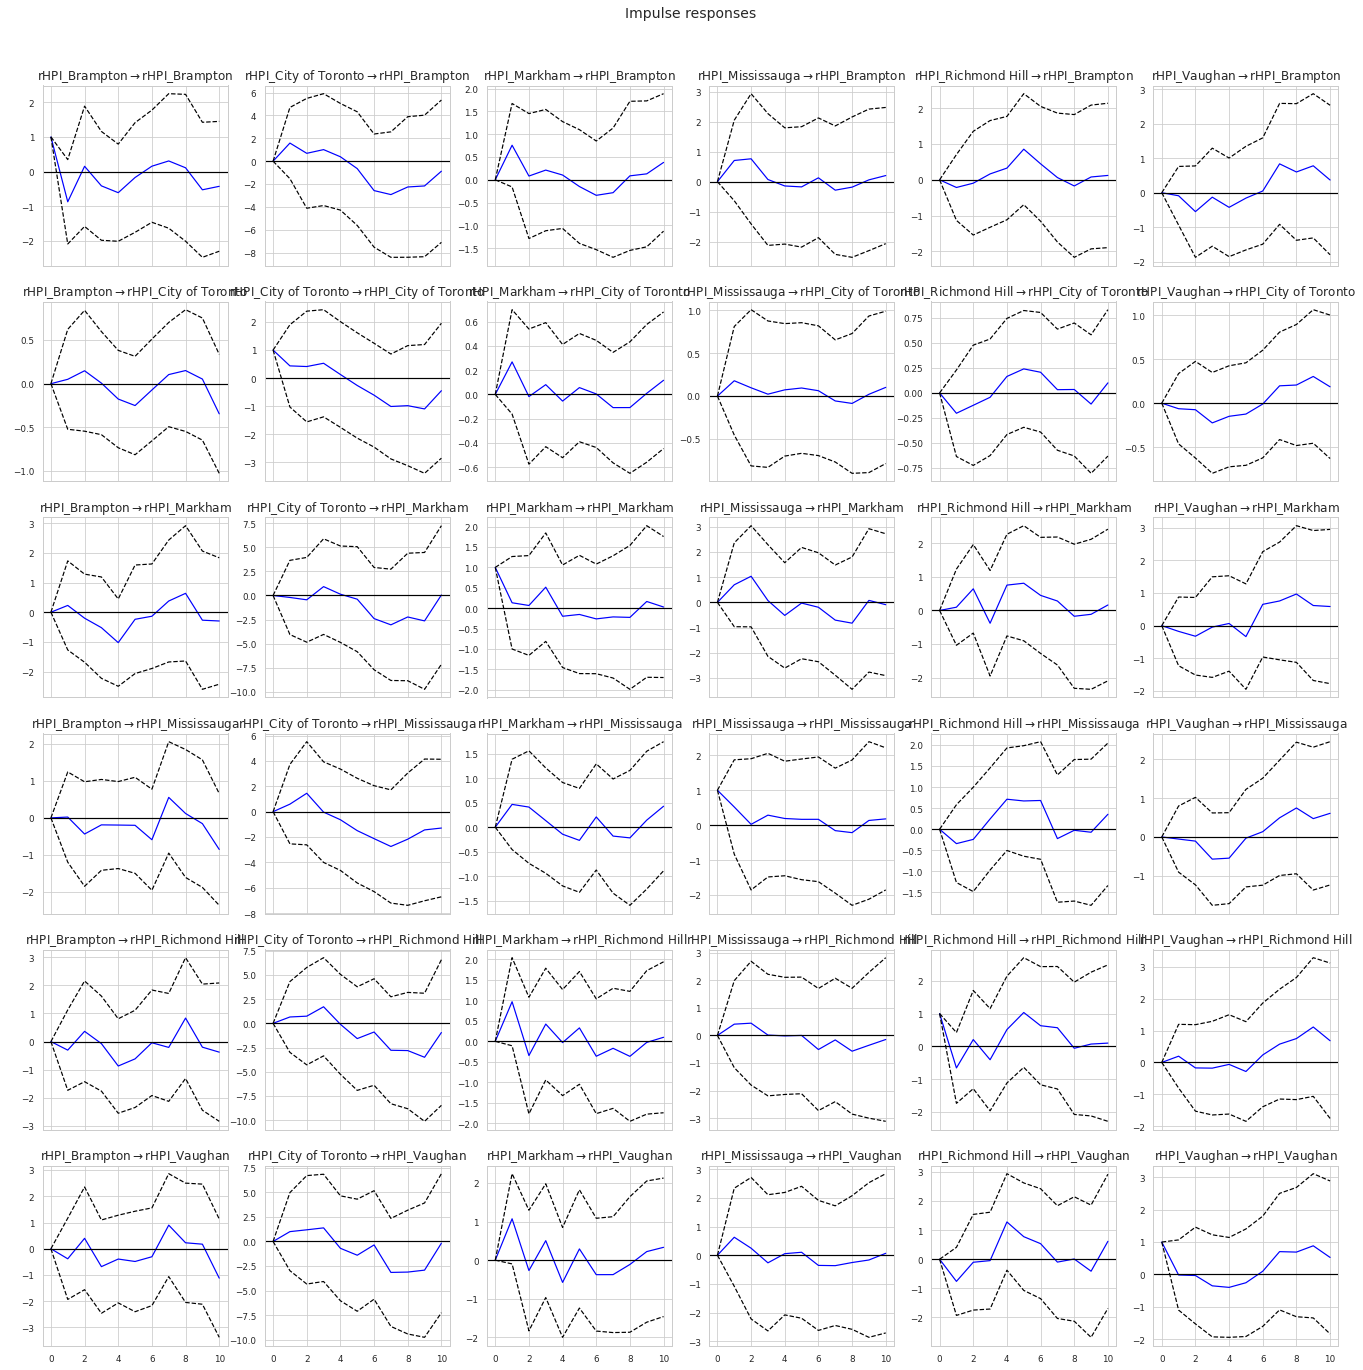

In [21]:
with sns.plotting_context("paper", font_scale=1):
    with sns.axes_style("whitegrid"):
        fig = irf.plot()
        fig.set_figwidth(20)
        fig.set_figheight(20)

In [22]:
granger_causality = dict()

### Research Question:

#### Does an increase in the Home Price Index of the City of Toronto "Granger-cause" an increase in the Home Price Index of Brampton?

In [23]:
endogenous_area = 'rHPI_Brampton'
exogenous_areas = ['rHPI_City of Toronto']
key = str([endogenous_area] + exogenous_areas)
granger_causality[key] = models[manually_selected_lag_order].test_causality(endogenous_area, exogenous_areas, kind='f')

In [24]:
granger_causality[key].summary()

Test statistic,Critical value,p-value,df
0.9740,2.272,0.452,"(6, 54)"


### Research Question:

#### Do increases in the Home Price Indices of the City of Toronto, Markham, Richmond Hill, Mississauge and Vaughan _jointly_ "Granger-cause" an increase in the Home Price Index of Brampton?

In [25]:
endogenous_area = 'rHPI_Brampton'
exogenous_areas = ['rHPI_City of Toronto', 'rHPI_Markham', 'rHPI_Richmond Hill', 'rHPI_Mississauga', 'rHPI_Vaughan']
key = str([endogenous_area] + exogenous_areas)
granger_causality[key] = models[manually_selected_lag_order].test_causality(endogenous_area, exogenous_areas, kind='f')

## Final word on "causality"

As I noted above, the model, the IRFs, and the test of Granger-"causality" do not present evidence of an "impact" of price changes in - say - City of Toronto on the price changes in Brampton. How would I have interpreted the results if I had seem evidence of such an "impact"? 

The wording "Granger-cause" can be misleading: even if the analysis were to present us evidence that a rise in City of Toronto prices "granger causes" a rise in Brampton prices, this does not mean that a rise in City of Toronto prices _actually causes_ a rise in Brmapton prices. 

When we talk about causality, if we are saying that a rise in City of Toronto prices cause an increase in Brampton prices, this implies the following: if we were to somehow induce a price increase in City of Toronto with a policy change that impacts only the prices in City of Toronto, this would still impact Brampton, indirectly. That is the usual interpretation of the word "causality". However, this is not a correct interpretation of this analysis and Granger causality in general. In particular, the VAR model above, as many other models, suffer from omitted variable bias. Therefore, all the underlying results and analyses (the IRF and the Granger causality) suffer from the same omitted variable bias.

For example, imagine an unobserved variable that impacts the prices in both Brampton _and_ the City of Toronto that we failed to reflect in the model. Then, particularly if this variable had this impact _at different times_, we would observe evidence of "Granger causality" between the two time series. Can we imagine that we collected all the relevant data regarding home prices? For instance, we do not necessarily observe all monetary transfers into Canada that are used to make a real estate purchase. These unobserved inbound money transfers may fluctuate due to political and regulatory changes in other countries and impact prices in differently for area to area. In this case, the underlying, actual cause would be the unobserved fluctuations in such transactions, and not an impact of one area's prices on the other. Due to our ommited variable bias, we would still observe Granger causality where there is no actual causality. Hence, this would be an example where "Granger causality" is not "causality". 

To prove actual "causality", we would need a sound "identification strategy" that convinces us that we found a way to address the omitted variable bias.